In [186]:
# Read Data
import numpy as np
import pandas as pd

In [187]:
%run ../src/campus_src.py

In [175]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [188]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
#n_steps = 8  # 例如，使用t以及前面5步作為特徵
#論文設定成3
n_steps = 3
X, y = create_dataset(df.to_numpy(), n_steps)

# 只取前面 90% 去建立 capacitiy model
num_samples = X.shape[0]
size = int(num_samples * 0.9)  # 取前 90%

X = X[:size]
y = y[:size]

print(y)
print(X.shape)
print(y.shape)


[222.326142 220.546435 205.955438 ...  67.375925 165.373307 208.169322]
(3884, 3, 35)
(3884,)


## Split

In [189]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.10) #剩下15做測試去看違規率

## Scaler

In [190]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [191]:
# 2. 設定成本權重 (可依商業需求調整)
C_SLA_weight  = 20.0   # 違約成本權重
C_over_weight = 1.0   # 過度配置成本權重
model = build_model_CAP(n_steps, X_train.shape[2], C_SLA=C_SLA_weight, C_over=C_over_weight)

/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_12 (TCN)                    │ (None, 64)             │        97,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [193]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - MAE: 85.5795 - loss: 1225.7922 - val_MAE: 217.9789 - val_loss: 217.9789
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - MAE: 151.4613 - loss: 176.7134 - val_MAE: 69.5258 - val_loss: 70.8052
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - MAE: 70.7546 - loss: 77.2070 - val_MAE: 29.7757 - val_loss: 32.7995
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - MAE: 32.7840 - loss: 41.7760 - val_MAE: 16.7156 - val_loss: 33.2289
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - MAE: 26.4573 - loss: 39.2599 - val_MAE: 27.6121 - val_loss: 28.7378
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - MAE: 27.1335 - loss: 35.4782 - val_MAE: 21.2319 - val_loss: 26.3091
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - MAE: 24.2579 - loss: 34.3549 - val_MAE: 26.7667 - val_loss: 28.8732
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - MAE: 27.3253 - loss: 33.7411 - val_MAE: 18.3227 - val_loss: 26.2207
Epoch 9/100
23/23 

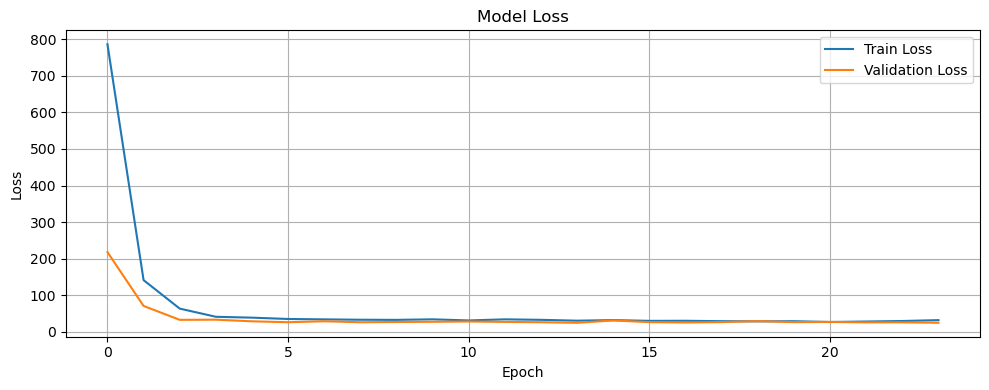

In [194]:
plot_loss(history)

In [195]:
model.save("../models/tf/capacity.keras")

Testing Length: 583
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


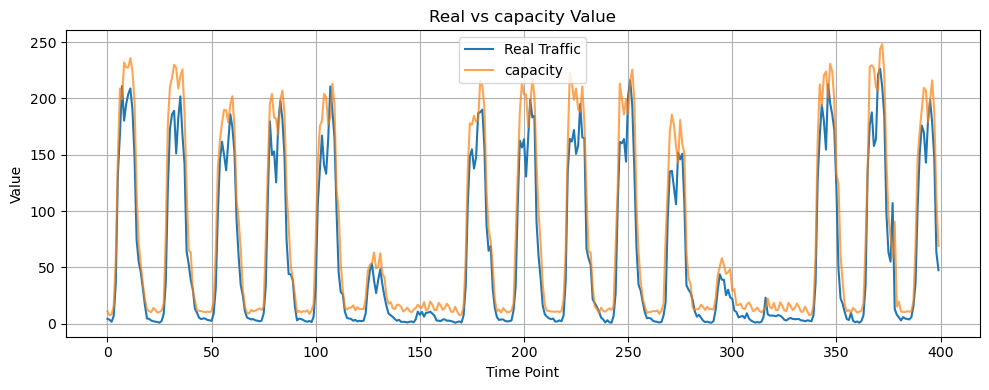

In [196]:
plot_predictions(model, X_test, y_test, start=0, end=400, label="capacity")

In [197]:
violation_rate, num_violations, total = compute_violation_rate(model, X_test, y_test)
print(f"違約率: {violation_rate*100:.2f}% ({num_violations}/{total})")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
違約率: 6.17% (36/583)


In [62]:
predicted = model.predict(X_test).reshape(-1, 1)
result_normal = evaluate_regression(y_test, predicted)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 19.827905654907227
Mean Squared Error: 768.3851318359375
Root Mean Squared Error: 27.719760674218264
R^2 Score: 0.8606623411178589
Mean Absolute Percentage Error: 1.7993296384811401


In [26]:
predicted = model.predict(X_test_adv).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 32.162349700927734
Mean Squared Error: 1383.37548828125
Root Mean Squared Error: 37.19375603890053
R^2 Score: 0.8411042094230652
Mean Absolute Percentage Error: 4.35919713973999


In [330]:
# Create a DataFrame to compare the values
df_compare = pd.DataFrame({
    'Metric': list(result_normal.keys()),
    'Normal': list(result_normal.values()),
    'Attacked': list(result_attacked.values())
})

# Calculate absolute and percentage differences
df_compare['Absolute Difference'] = df_compare['Attacked'] - df_compare['Normal']
df_compare['% Difference'] = ((df_compare['Absolute Difference'] / df_compare['Normal']) * 100)
df_compare

,Metric,Normal,Attacked,Absolute Difference,% Difference
0,MAE,6.848458,9.084687,2.236229,32.653036
1,MSE,110.009964,157.027420,47.017456,42.739270
2,RMSE,10.488563,12.531058,2.042495,19.473541
3,R2,0.987364,0.981964,-0.005400,-0.546959
4,MAPE,0.382416,0.767118,0.384701,100.597517


In [ ]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

# 結果分析

## 每小時誤差

In [ ]:
for index, row in df_extraction.iterrows():
  for i in range(len(y_test)):
    if (row["value_avg"]/1000000) == y_test[i]:
      df_extraction.loc[index, "predicted"] = predicted[i][0]

In [ ]:
df_extraction_hour = df_extraction.dropna()

In [ ]:
df_extraction_hour["value_avg"] = df_extraction_hour["value_avg"] / 1000000

In [ ]:
df_extraction_hour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["hour"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(24)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each hour')
plt.xticks(hours)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["weekday"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(7)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each weekday')
plt.xticks(hours)
plt.legend()
plt.show()